<h1 align="center" style="margin-top:10px">BUSS6002 Data Science in Business</h1>
<h2 align="center" style="margin-top:10px">Group Assignment</h2>

<h3 align="right" style="margin-top:10px">Group number: RE367</h3>

In [1]:
# Import packages
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import warnings
warnings.filterwarnings('ignore') 

# Connect to database
conn = sqlite3.connect('cafe_insomnia.sqlite') 

## 1. What affects Café Insomnia’s hourly sales (in AUD)?

### Previous EDA

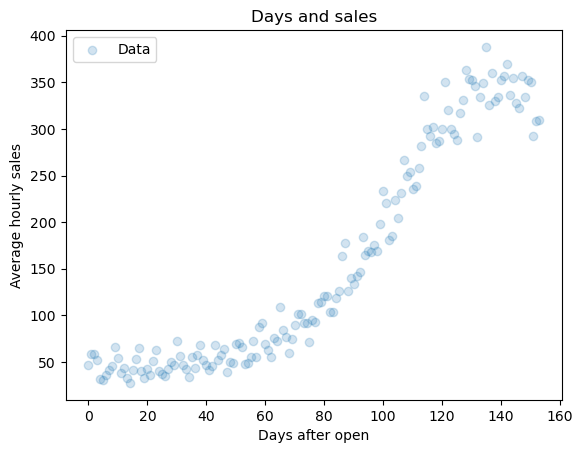

In [2]:
# Prepare data 
query = '''SELECT hours_after_open, days_after_open, day_of_week, date, quantity*unit_price AS sales, d.name drink_name, s.name study_area_name, dist_to_cafe, raining
           FROM ci_transaction c
           JOIN drink d
           ON c.drink_id = d.id
           JOIN study_area s
           ON c.study_area_id = s.id
           WHERE c.raining ='Yes' or c.raining = 'No';'''
df = pd.read_sql(query, conn)

daily_sales = df.groupby(['days_after_open']).sum()
daily_sales = daily_sales.drop(['hours_after_open'], axis=1)
daily_sales["hourly_sales"] = daily_sales['sales']/6
hourly_sales=daily_sales['hourly_sales'].round(2)

# Plotting
x = np.arange(154)
y = hourly_sales.to_numpy()
plt.scatter(x,y, alpha=0.2, label="Data")
plt.xlabel("Days after open")
plt.ylabel("Average hourly sales")
plt.title("Days and sales")
plt.legend()
plt.show("plot.png")


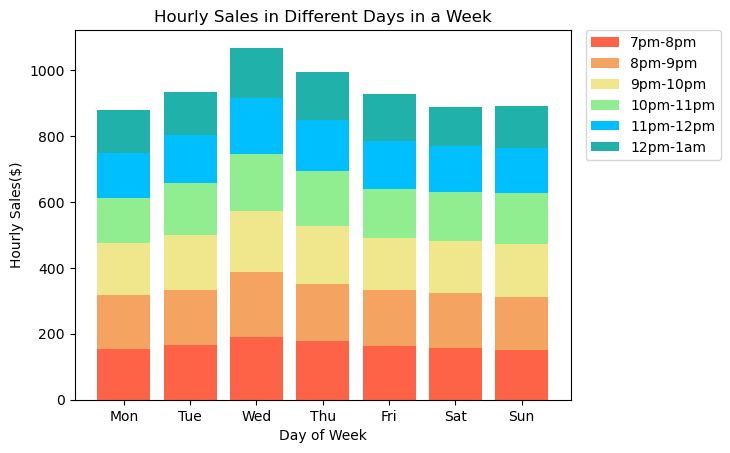

In [3]:
# Querying sales in each day-of-the-week and group them by hours-after-open, at the same time store all the result into a list
day = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
list = []
for i in day:
    list.append(np.divide(df.query('day_of_week == @i').groupby('hours_after_open').sum()['sales'],22))
    
# Link all the results in the list together into one dataframe, and store it as table 3
table_3 = pd.concat(list, axis = 1, ignore_index = False, join = 'outer')
table_3.columns = day # change the names of the columns in table 3

# Visualize table 3 using stacked bar chart, and label the hours-after-open by time periods to make it easier to understand
plt.bar(day,table_3.iloc[0], color = 'tomato', label = '7pm-8pm')
plt.bar(day,table_3.iloc[1], bottom = table_3.iloc[0], color = 'sandybrown', label = '8pm-9pm')
plt.bar(day,table_3.iloc[2], bottom = table_3.iloc[0]+table_3.iloc[1], color = 'khaki', label = '9pm-10pm')
plt.bar(day,table_3.iloc[3], bottom = table_3.iloc[0]+table_3.iloc[1]+table_3.iloc[2], color = 'lightgreen', label = '10pm-11pm')
plt.bar(day,table_3.iloc[4], bottom = table_3.iloc[0]+table_3.iloc[1]+table_3.iloc[2]+table_3.iloc[3], color = 'deepskyblue', label = '11pm-12pm')
plt.bar(day,table_3.iloc[5], bottom = table_3.iloc[0]+table_3.iloc[1]+table_3.iloc[2]+table_3.iloc[3]+table_3.iloc[4], color = 'lightseagreen', label = '12pm-1am')

plt.xlabel('Day of Week')
plt.ylabel('Hourly Sales($)')
plt.title('Hourly Sales in Different Days in a Week')
plt.legend(bbox_to_anchor = (1.03,1), loc = 2, borderaxespad = 0) # move the legend outside
plt.show()

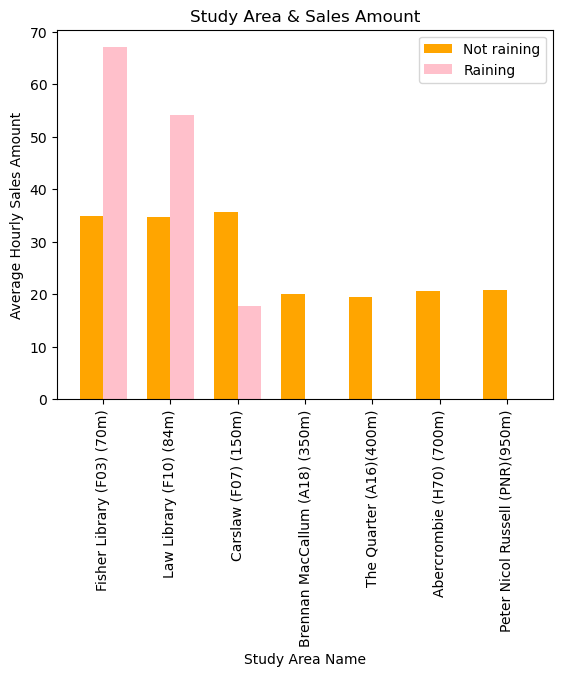

In [4]:
''' The missing values have been identified, the appropriate data can be extracted by using a combination of SQL code.
    Using INNER JOIN to filter out the missing value (-1) for studying _area_id, and using WHERE to filter out the
    missing value (NA) for raining'''



# since the ic_transaction only record transaction unit and unit price 
# without specifying the amount for each transaction
# It is necessary to add a clumn to sum up the sales for each transaction

'''The date and hours after open have been recorded separately. This analysis is to identify the hourly sales
so that the date and hours after open should be combined to facilitate further calculation '''

df['Sales_hour'] = df['date']+'/'+ df['hours_after_open'].astype(str)

# Extract specific rows (raining with 'No') using loc function
rain_n = df.loc[df['raining'] == 'No']
# Identify which study area makes purchases when it is not raining
'''Use GROUPBY function to get the sum of sales categorized by study area name, 
    distance to cafe, and sales hour in no raining'''
rain_n_a= rain_n.groupby(['study_area_name', 'dist_to_cafe', 'Sales_hour']).sum()['sales']
rain_n_a = rain_n_a.reset_index()

# Get the mean of sales per hour when it is not raining
rain_n_a = rain_n_a.groupby(['study_area_name', 'dist_to_cafe']).mean()['sales']
rain_n_a = rain_n_a.reset_index()

# Reorder the table referring to the distance to cafe
rain_n_a = rain_n_a.sort_values('dist_to_cafe',ascending =True)
rain_n_a = rain_n_a.reset_index()

# Delete duplicated index
rain_n_a = rain_n_a.drop(['index'], axis = 1)
'''Since there are only three study areas make purchase in rainy day, loc() function is used to add in the 
   rest of the study areas. So that a combination bar chart can be created.
   iloc() function is learnt in week 3, and to add in the raws in a dataframe, loc() is used 
   source from: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html?highlight=loc#pandas.DataFrame.loc'''
rain_y = df.loc[df['raining'] == 'Yes']
# Identify which study area made purchases in rainy day
'''Use GROUPBY function to get the sum of sales categorized by study area name, 
    distance to cafe, and sales hour in rainy day'''
rain_y_a = rain_y.groupby(['study_area_name', 'dist_to_cafe', 'Sales_hour']).sum()['sales']
rain_y_a = rain_y_a.reset_index()

# Get the mean of sales per hour in rainy day
rain_y_a = rain_y_a.groupby(['study_area_name', 'dist_to_cafe']).mean()['sales']
rain_y_a = rain_y_a.reset_index()

# Reorder the table referring the distance to cafe
rain_y_a = rain_y_a.sort_values('dist_to_cafe',ascending =True)
rain_y_a = rain_y_a.reset_index()

# Delete duplicated index
rain_y_a = rain_y_a.drop(['index'], axis = 1)

rain_y_a.loc[4] = (['Brennan MacCallum (A18)', 350, 0])
rain_y_a.loc[5] = (['The Quarter (A16)', 400, 0])
rain_y_a.loc[6] = (['Abercrombie (H70)',700,0])
rain_y_a.loc[7] = (['Peter Nicol Russell (PNR)', 950,0])
'''A combination bar chart is used to visually identify the aveage hourly sales in difference whether 
   categorized in different areas
   source from: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html'''

# Create labels for x axis 
labels = ['Fisher Library (F03) (70m)', 'Law Library (F10) (84m)',
         'Carslaw (F07) (150m)', 'Brennan MacCallum (A18) (350m)',
         'The Quarter (A16)(400m)', 'Abercrombie (H70) (700m)',
         'Peter Nicol Russell (PNR)(950m)']

# Specify label locations
location = np.arange(len(labels))

# Specify the width of the bars
width = 0.35  

# Assign attributes to the bars, and specify the width, color, label
plt.bar(location, rain_n_a['sales'], width,color = 'orange', label='Not raining')
plt.bar(location + width, rain_y_a['sales'], width, color = 'pink', label='Raining')


plt.ylabel('Average Hourly Sales Amount')
plt.xlabel('Study Area Name')
plt.title('Study Area & Sales Amount')
plt.xticks(location + width/2, labels)
plt.legend()
plt.xticks(rotation = 90)

plt.show()

### Further EDA

In [5]:
query = '''SELECT d.name, d.unit_price, c.raining, c.quantity,s.dist_to_cafe, quantity*unit_price AS sales, c.days_after_open,c.hours_after_open, s.name as study_area_name, c.day_of_week
           FROM ci_transaction c
           JOIN drink d
           ON c.drink_id = d.id
           JOIN study_area s 
           ON c.study_area_id = s.id
           ;'''
dn = pd.read_sql(query, conn)
##dn_sale= dn.groupby(['name','unit_price']).sum()['sales'].sort_values()
dn_sale= dn.groupby(['name','unit_price']).sum()['quantity'].sort_values()
dn_sale

name               unit_price
Ristretto          3.3           1889
Latte (L)          4.9           1947
Hot Chocolate (S)  3.8           1948
Long Black (L)     4.0           1997
Mocha (L)          5.4           2001
Espresso           3.5           2003
Latte (S)          4.0           2012
Cappuccino (S)     4.0           2013
Chai Latte (L)     4.4           2038
Flat White (L)     4.9           2041
Macchiato          3.8           2052
Chai Latte (S)     3.6           2064
Cappuccino (L)     4.9           2065
Flat White (S)     4.0           2087
Mocha (S)          4.5           2091
Hot Chocolate (L)  4.6           2092
Long Black (S)     3.8           2096
Name: quantity, dtype: int64

In [6]:
query = '''SELECT sum(c.quantity*d.unit_price) as hourly_sales,c.days_after_open,c.hours_after_open,c.day_of_week,sum(c.quantity) as quantity,c.raining,s.dist_to_cafe,s.name as study_area_name
           FROM ci_transaction c
           JOIN drink d
           ON c.drink_id = d.id
           JOIN study_area s 
           ON c.study_area_id = s.id
           GROUP BY c.days_after_open, c.hours_after_open;'''
df = pd.read_sql(query, conn)

In [7]:
df

,hourly_sales,days_after_open,hours_after_open,day_of_week,quantity,raining,dist_to_cafe,study_area_name
0,49.0,0,0,Mon,11,No,700,Abercrombie (H70)
1,83.6,0,1,Mon,21,No,150,Carslaw (F07)
2,37.3,0,2,Mon,8,Yes,84,Law Library (F10)
3,50.6,0,3,Mon,12,No,700,Abercrombie (H70)
4,16.1,0,4,Mon,4,Yes,150,Carslaw (F07)
...,...,...,...,...,...,...,...,...
919,364.7,153,1,Sun,83,No,84,Law Library (F10)
920,326.1,153,2,Sun,77,No,84,Law Library (F10)
921,266.0,153,3,Sun,63,Yes,84,Law Library (F10)
922,320.7,153,4,Sun,78,No,70,Fisher Library (F03)


#### Clustering

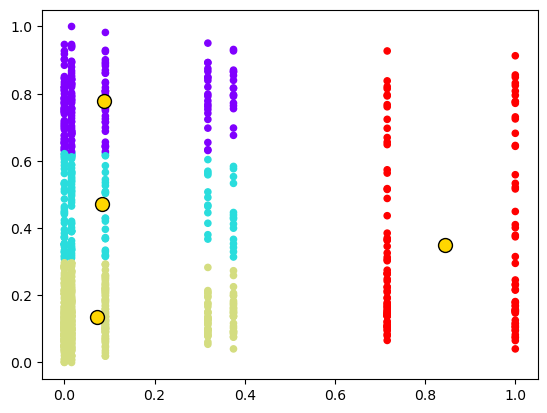

In [8]:
data = df[['dist_to_cafe', 'hourly_sales']].to_numpy()

# Rescale the x and y values between 0 and 1
data_r = (data - data.min(axis = 0))/(data.max(axis = 0) - data.min(axis = 0))

# Initialise centroids
k = 4
np.random.seed(1)
centroids = np.random.rand(k, 2)

# Repeat Cluster assignments
labels = np.zeros(data.shape[0])

converged = False
while converged == False:
    
    # Cluster assignments
    new_labels = np.zeros(data.shape[0])
    dists = np.zeros(k)
    for i in range(data.shape[0]):
        for j in range(k):
            dists[j] = np.linalg.norm(centroids[j] - data_r[i])
        new_labels[i] = np.argmin(dists)
    # Mean of each cluster
    for i in range(k):
        centroids[i] = data_r[new_labels == i].mean(axis = 0)
    
    if np.array_equal(labels, new_labels):
        converged = True
    labels = new_labels


# Plot
plt.scatter(data_r[:,0], data_r[:,1], s = 20, label = 'Data', cmap = 'rainbow', c = labels)
plt.scatter(centroids[:,0], centroids[:,1], s = 100, color = 'gold', edgecolors = 'black', label = 'Centroids')

#### Get dummies

In [9]:
df = pd.get_dummies(df, drop_first = True)
df

,hourly_sales,days_after_open,hours_after_open,quantity,dist_to_cafe,day_of_week_Mon,day_of_week_Sat,day_of_week_Sun,day_of_week_Thu,day_of_week_Tue,day_of_week_Wed,raining_Yes,study_area_name_Brennan MacCallum (A18),study_area_name_Carslaw (F07),study_area_name_Fisher Library (F03),study_area_name_Law Library (F10),study_area_name_Peter Nicol Russell (PNR),study_area_name_The Quarter (A16)
0,49.0,0,0,11,700,1,0,0,0,0,0,0,0,0,0,0,0,0
1,83.6,0,1,21,150,1,0,0,0,0,0,0,0,1,0,0,0,0
2,37.3,0,2,8,84,1,0,0,0,0,0,1,0,0,0,1,0,0
3,50.6,0,3,12,700,1,0,0,0,0,0,0,0,0,0,0,0,0
4,16.1,0,4,4,150,1,0,0,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,364.7,153,1,83,84,0,0,1,0,0,0,0,0,0,0,1,0,0
920,326.1,153,2,77,84,0,0,1,0,0,0,0,0,0,0,1,0,0
921,266.0,153,3,63,84,0,0,1,0,0,0,1,0,0,0,1,0,0
922,320.7,153,4,78,70,0,0,1,0,0,0,0,0,0,1,0,0,0


#### Heatmap

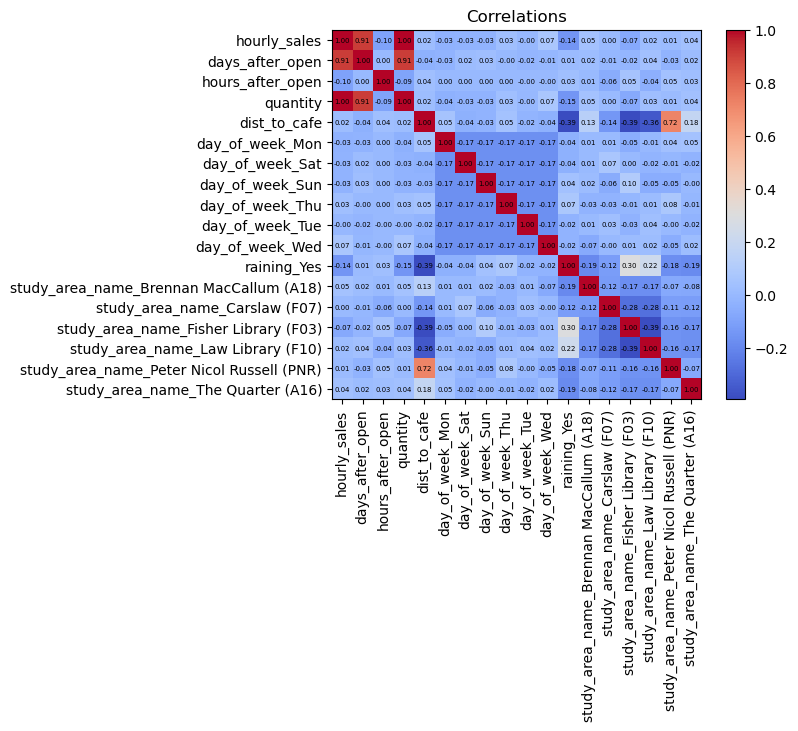

In [10]:
corr = df.corr()
n_var = len(corr) # Number of variables

# Plot the heatmap
plt.imshow(corr, cmap = 'coolwarm')

plt.xticks(range(n_var), corr.columns)
plt.yticks(range(n_var), corr.columns)
plt.xticks(rotation = 90)
for i in range(n_var):
    for j in range(n_var):
        #              format to 2 decimal places  ,  horizonta/vertical align center  
        plt.text(i, j, '{:.2f}'.format(corr.iloc[i, j]), ha="center", va="center", color="k", fontsize = 5)

plt.colorbar()

plt.title('Correlations')
plt.show('correlation.png')


#### Cross tablulation

In [11]:
pd.crosstab(dn['study_area_name'],dn['day_of_week'])

day_of_week,Fri,Mon,Sat,Sun,Thu,Tue,Wed
study_area_name,,,,,,,
Abercrombie (H70),306,281,289,243,281,276,348
Brennan MacCallum (A18),271,256,271,284,270,279,372
Carslaw (F07),667,635,652,611,710,667,786
Fisher Library (F03),1035,968,984,1048,1248,1094,1167
Law Library (F10),941,927,917,980,1144,997,1011
Peter Nicol Russell (PNR),318,268,274,258,247,284,360
The Quarter (A16),291,272,258,269,224,286,346


In [12]:
pd.crosstab(dn['study_area_name'],dn['quantity'])


quantity,1,2,3,4
study_area_name,,,,
Abercrombie (H70),1593,325,61,45
Brennan MacCallum (A18),1625,282,54,42
Carslaw (F07),3785,721,129,93
Fisher Library (F03),6074,1072,230,168
Law Library (F10),5572,1025,193,127
Peter Nicol Russell (PNR),1579,316,69,45
The Quarter (A16),1582,277,46,41


#### Statistical testing

In [13]:
from scipy import stats
l = df.columns.values.tolist()
for i in l:
    print(i,stats.pearsonr(df[i],df['hourly_sales']))

hourly_sales (0.9999999999999999, 0.0)
days_after_open (0.9100491301573521, 0.0)
hours_after_open (-0.09503652218143581, 0.003834118955951996)
quantity (0.9992997743933565, 0.0)
dist_to_cafe (0.02037361262371606, 0.5362259755525863)
day_of_week_Mon (-0.03452317293595411, 0.2944978535536402)
day_of_week_Sat (-0.029482691763846446, 0.37069210682413023)
day_of_week_Sun (-0.027918493363299747, 0.3966244659241879)
day_of_week_Thu (0.03100565923455998, 0.3464789199354342)
day_of_week_Tue (-0.003852515006288807, 0.9069010785045987)
day_of_week_Wed (0.07234739719167807, 0.027872533420007527)
raining_Yes (-0.14427516689382358, 1.0691073329893522e-05)
study_area_name_Brennan MacCallum (A18) (0.04925016662686288, 0.13466491493559463)
study_area_name_Carslaw (F07) (0.0034789807430824224, 0.9158925624110416)
study_area_name_Fisher Library (F03) (-0.06796016258705408, 0.0388849852522575)
study_area_name_Law Library (F10) (0.02445365673662208, 0.45782586726755986)
study_area_name_Peter Nicol Russell 

In [14]:
pd.crosstab(df['dist_to_cafe'],df['raining_Yes'])

raining_Yes,0,1
dist_to_cafe,,
70,117,141
84,131,127
150,124,31
350,66,0
400,63,0
700,68,0
950,56,0


## 2. Can a model be built to predict hourly sales (in AUD)?

### Data preparation

In [15]:
df = df[['hourly_sales','days_after_open','hours_after_open','day_of_week_Wed','raining_Yes','study_area_name_Fisher Library (F03)']]
df

,hourly_sales,days_after_open,hours_after_open,day_of_week_Wed,raining_Yes,study_area_name_Fisher Library (F03)
0,49.0,0,0,0,0,0
1,83.6,0,1,0,0,0
2,37.3,0,2,0,1,0
3,50.6,0,3,0,0,0
4,16.1,0,4,0,1,0
...,...,...,...,...,...,...
919,364.7,153,1,0,0,0
920,326.1,153,2,0,0,0
921,266.0,153,3,0,1,0
922,320.7,153,4,0,0,1


### Model Building and evaluation

1. Multiple linear regression - model building

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import r2_score

# Prepare data
X = df.iloc[:,1:]
y = df['hourly_sales']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Build and fit regression model
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Print out β model parameters
print('beta 0: {:.8f}'.format(linear_reg.intercept_))
for i in np.arange(1, 6):
    print('beta {}: {:.8f}'.format(i, linear_reg.coef_[i-1]))

beta 0: -7.61416531
beta 1: 2.44786626
beta 2: -6.46555487
beta 3: 26.23694970
beta 4: -38.38563866
beta 5: -0.64306667


1. Multiple linear regression - evaluation

In [17]:
# Predict on the test data
y_pred = linear_reg.predict(X_test)

# Calculate the MSE and R^2
print('Multiple linear regression model:')
print("MSE: {:.4f}".format(mse(y_pred,y_test)))
print("R_square: {:.4f}".format(r2_score(y_test, y_pred)))

Multiple linear regression model:
MSE: 2181.5274
R_square: 0.8625


2. Polynomial regression - model building

In [18]:
# Generate data for polynomial regression
df['days_after_open^2'] = df['days_after_open']**2
df['days_after_open^3'] = df['days_after_open']**3
df['days_after_open^4'] = df['days_after_open']**4
df['days_after_open^5'] = df['days_after_open']**5
df['days_after_open^6'] = df['days_after_open']**6
df['days_after_open^7'] = df['days_after_open']**7
df['days_after_open^8'] = df['days_after_open']**8

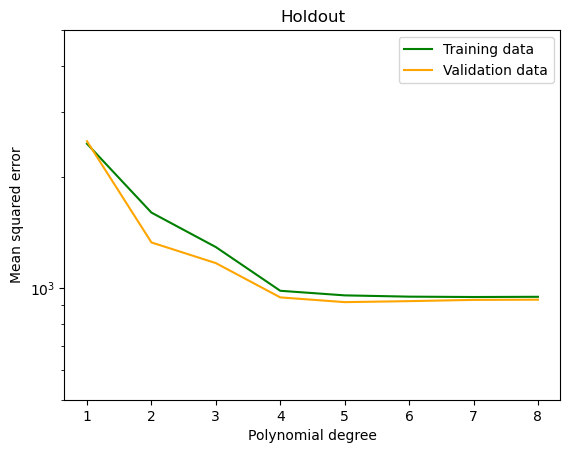

In [19]:
# Prepare data
X = df[['days_after_open', 'days_after_open^2','days_after_open^3','days_after_open^4',
        'days_after_open^5','days_after_open^6','days_after_open^7','days_after_open^8']].to_numpy()
y = df['hourly_sales'].to_numpy()

# Train-vali-test split
X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)
X_train, X_vali, y_train, y_vali = train_test_split(X_tv, y_tv, test_size=1/4, random_state = 1)

mse_train = []
mse_vali = []

max_deg = 8
degrees = range(1, max_deg+1)

for deg in degrees:

    # Build and fit regression model
    linear_reg = LinearRegression()
    linear_reg.fit(X_train[:, :deg], y_train)

    # Predict with regression model
    pred_train = linear_reg.predict(X_train[:, :deg])
    pred_vali = linear_reg.predict(X_vali[:, :deg])

    # Calculate and save the MSE
    mse_train.append(mse(y_train, pred_train))
    mse_vali.append(mse(y_vali, pred_vali))


# Plot the holdout results 
plt.plot(degrees, mse_train, color = 'green', label = 'Training data')
plt.plot(degrees, mse_vali, color = 'orange', label = 'Validation data')
plt.xlabel('Polynomial degree')
plt.ylabel('Mean squared error')
plt.title('Holdout')
plt.xticks(degrees)
plt.yscale('log')
plt.ylim([5e2, 5e3])
plt.legend()
plt.savefig('plot.png')

In [20]:
# Build and fit your regression model on the combined training and validation data
deg = 5
linear_reg = LinearRegression()
linear_reg.fit(X_tv[:, :deg], y_tv)

# Print out β model parameters
print('beta 0: {:.8f}'.format(linear_reg.intercept_))
for i in np.arange(1, 6):
    print('beta {}: {:.8f}'.format(i, linear_reg.coef_[i-1]))

beta 0: 45.12208976
beta 1: -0.35853563
beta 2: 0.03191192
beta 3: -0.00092725
beta 4: 0.00001308
beta 5: -0.00000005


2. Polynomial regression - evaluation

In [21]:
# Predict on the test data
y_pred = linear_reg.predict(X_test[:,:deg])

# Calculate the MSE and R^2
print('Polynomial regression model:')
print("MSE: {:.4f}".format(mse(y_pred,y_test)))
print("R_square: {:.4f}".format(r2_score(y_test, y_pred)))

Polynomial regression model:
MSE: 860.0596
R_square: 0.9474


## 3. Reflection and Future work
